# Harmonic Regression

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

$ f(x) = a_0 + \sum_{i=1}^n \left[ a_i \cdot cos \left( \cfrac{2 \cdot \pi \cdot i \cdot x}{T} \right) + b_i \cdot sin \left( \cfrac{2 \cdot \pi \cdot i \cdot x}{T} \right) \right] $

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
start = time.time()

# 1. Read DataFrame

In [5]:
df = pd.read_csv('Temp.csv', skiprows = [3652])

In [6]:
df = df.rename(columns = {'Date': 'Time', 'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'X_t'})

In [7]:
df['Time'] = pd.to_datetime(df['Time'])

In [8]:
def transform_date(date):

    try:

        new_date = date.year + (date.month - 1)/12 + date.day/365

        return new_date
    
    except:

        return float('nan')

In [9]:
def transform_value(value):

    try:

        return float(value)
    
    except:

        return float('nan')

In [10]:
df['Time'] = df['Time'].map(lambda x: transform_date(x))

In [11]:
df['X_t'] = df['X_t'].map(lambda x: transform_value(x))

In [12]:
df = df.dropna()

# 2. Split

In [13]:
train = df[df['Time'] <= 1986.005479]
val = df[(df['Time'] > 1986.005479) & (df['Time'] <= 1988.504110)]
test = df[df['Time'] > 1988.504110]

# 3. Training model

In [14]:
T = 1

for i in range(1, 20 + 1):

    train[f'arg_{i}'] = (2*math.pi*train['Time']*i)/T
    train[f'sin_{i}'] = np.sin(train[f'arg_{i}'])
    train[f'cos_{i}'] = np.cos(train[f'arg_{i}'])

    val[f'arg_{i}'] = (2*math.pi*val['Time']*i)/T
    val[f'sin_{i}'] = np.sin(val[f'arg_{i}'])
    val[f'cos_{i}'] = np.cos(val[f'arg_{i}'])

    test[f'arg_{i}'] = (2*math.pi*test['Time']*i)/T
    test[f'sin_{i}'] = np.sin(test[f'arg_{i}'])
    test[f'cos_{i}'] = np.cos(test[f'arg_{i}'])

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
MSE_val = []
MSE_train = []
iterations = []

for i in range(1, 20 + 1):

    names = [f'sin_{t}' for t in range(1, i + 1)] + [f'cos_{t}' for t in range(1, i + 1)]

    reg = LinearRegression().fit(train[names], train['X_t'])

    train[f'predict_{i}'] = reg.predict(train[names])
    val[f'predict_{i}'] = reg.predict(val[names])

    MSE_train.append(((train[f'predict_{i}'] - train['X_t'])**2).mean())
    MSE_val.append(((val[f'predict_{i}'] - val['X_t'])**2).mean())

    iterations.append(i)

ht = pd.DataFrame()

ht['MSE_train'] = MSE_train
ht['MSE_val'] = MSE_val

ht['iterations'] = iterations

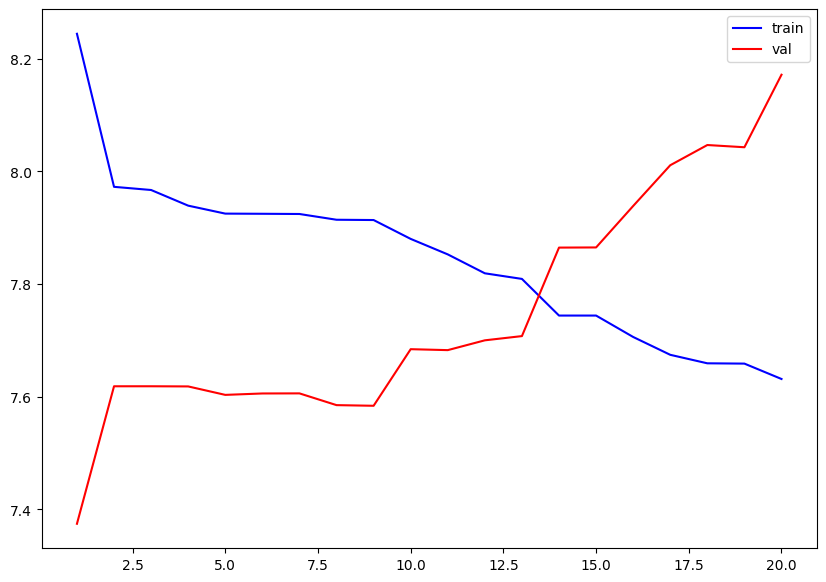

In [17]:
plt.figure(figsize = (10, 7))
plt.plot(ht['iterations'], ht['MSE_train'], label = 'train', color = 'blue')
plt.plot(ht['iterations'], ht['MSE_val'], label = 'val', color = 'red')
plt.legend()
plt.show()

**Comments:** Optimal is when $ n = 1 $.

# 4. Definitive model

In [18]:
reg = LinearRegression().fit(train[['sin_1', 'cos_1']], train['X_t'])

In [19]:
train['predict_def'] = reg.predict(train[['sin_1', 'cos_1']])
val['predict_def'] = reg.predict(val[['sin_1', 'cos_1']])
test['predict_def'] = reg.predict(test[['sin_1', 'cos_1']])

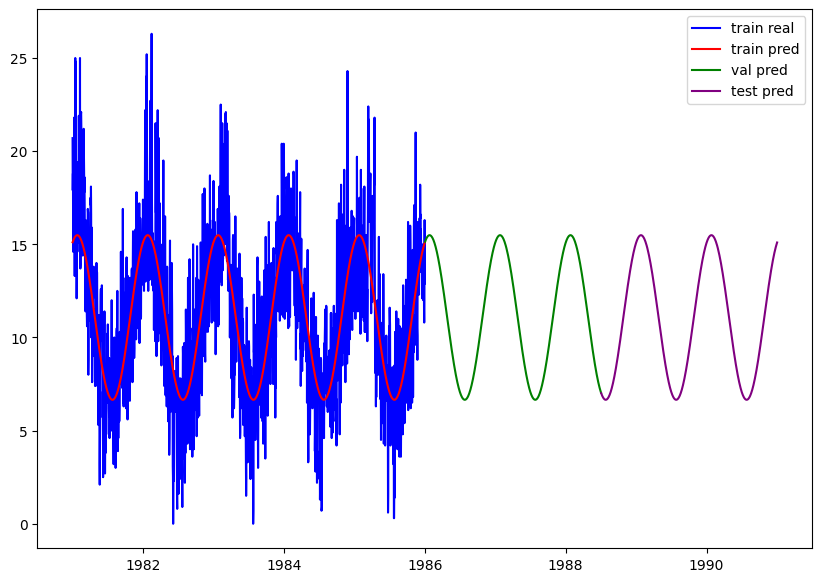

In [20]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'], label = 'train real', color = 'blue')
plt.plot(train['Time'], train['predict_def'], label = 'train pred', color = 'red')
plt.plot(val['Time'], val['predict_def'], label = 'val pred', color = 'green')
plt.plot(test['Time'], test['predict_def'], label = 'test pred', color = 'purple')
plt.legend()
plt.show()

# 5. Performance

In [21]:
round(((train['predict_def'] - train['X_t'])**2).mean(), 2)

8.24

In [22]:
round(((val['predict_def'] - val['X_t'])**2).mean(), 2)

7.37

In [23]:
round(((test['predict_def'] - test['X_t'])**2).mean(), 2)

7.05

# 6. Error

In [24]:
train['error'] = train['X_t'] - train['predict_def']
val['error'] = val['X_t'] - val['predict_def']
test['error'] = test['X_t'] - test['predict_def']

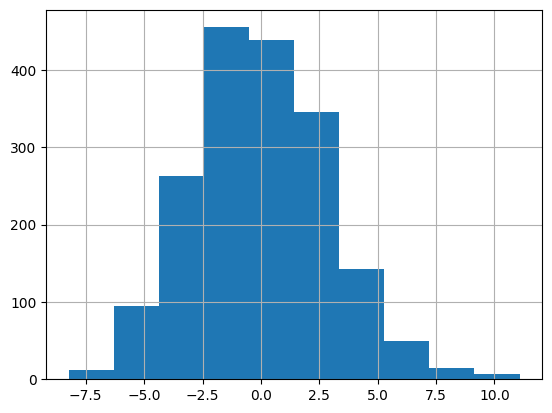

In [25]:
train['error'].hist()
plt.show()

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

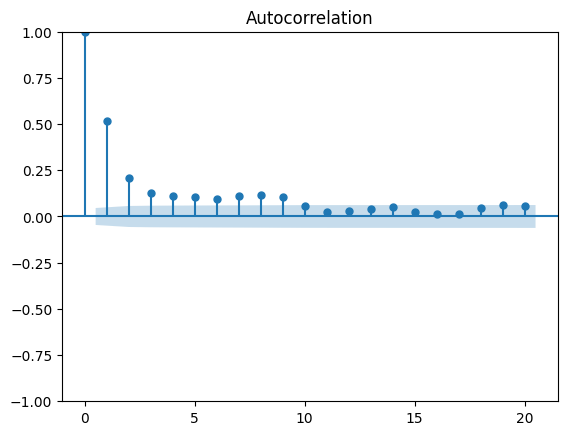

In [27]:
plot_acf(train['error'], lags = 20)
plt.show()

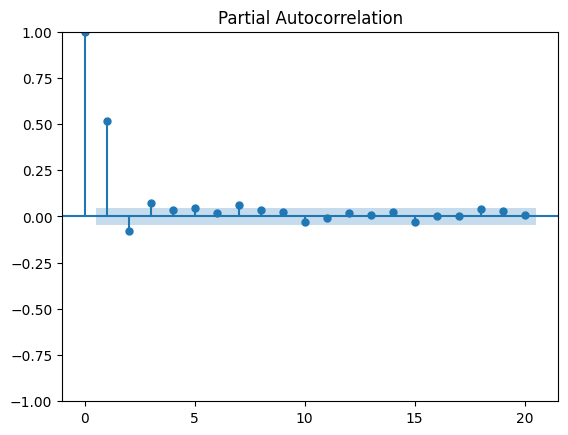

In [28]:
plot_pacf(train['error'], lags = 20)
plt.show()

### Time of execution

In [29]:
end = time.time()

In [30]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 1 seconds.
